In [1]:
import pandas as pd
import numpy as np

In [2]:
#Connect to database

import mysql.connector
import time
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="password",
  database="valorant_tracker"
)
cursor = mydb.cursor() 

In [3]:
df = pd.read_sql("SELECT * FROM stats", mydb)
print("Number of samples: " + str(df.shape[0]))

Number of samples: 2380703


In [4]:
df['user_id'] = df['match_player_id'].str[36:]


In [5]:
print(df.columns)

Index(['match_player_id', 'rounds', 'date', 'result', 'map', 'smurf', 'agent',
       'kills', 'headshots', 'deaths', 'assists', 'damage', 'damage_received',
       'econ_rating', 'plants', 'defuses', 'first_bloods', 'grenade_casts',
       'ability_2_casts', 'ability_1_casts', 'ultimate_casts', 'placement',
       'kdratio', 'headshot_percentage', 'first_deaths', 'last_deaths',
       'current_rank', 'user_id'],
      dtype='object')


In [6]:
data = df.drop(["match_player_id", 
"user_id", 
"date", 
"rounds", 
"map", 
"result", 
"agent",
"smurf",
"current_rank",], axis=1)

#Should eventually take into account ability casts for each agent
data = data.drop(["grenade_casts",
"ability_2_casts",
"ability_1_casts",
"ultimate_casts"
], axis=1)


Working with the raw data is difficult since it is not very gaussian. Will instead average all stats and work with a dataset of users.

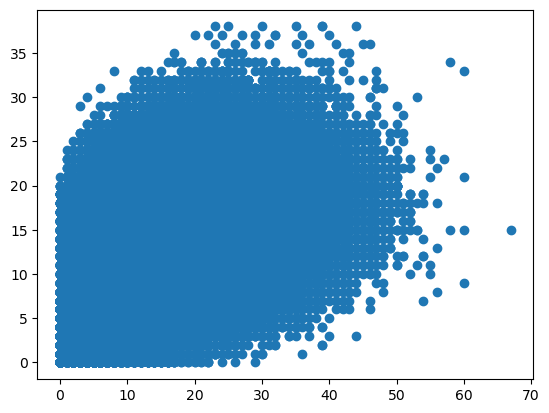

In [7]:
import matplotlib.pyplot as plt

plt.scatter(df["kills"], df["deaths"])

No validation set or test set being used to find optimal epsilon (should consider doing that, however, 0.000001 seems to work fairly well). After checking the accounts below, some of them appear to have two different users. One plays extremely well and the other plays poorly.

In [8]:
sub_data = df[["kills", "deaths", "user_id"]]
avg_data = sub_data.groupby("user_id").mean()


In [9]:
from sklearn.ensemble import IsolationForest

isof = IsolationForest(n_estimators=500, max_samples='auto', contamination=float(0.006))
clf = isof.fit(avg_data)

In [10]:
anomaly = clf.predict(avg_data)

In [11]:
test_anomaly = avg_data
test_anomaly["anomaly"] = anomaly.tolist()


In [12]:
anomalies = test_anomaly[(test_anomaly["anomaly"] == -1)]

In [13]:
anomalies.shape[0]

52

In [14]:
anom_true = anomalies[(anomalies["anomaly"] == -1)]

Text(0.5, 1.0, 'Kills Vs Deaths Outliers')

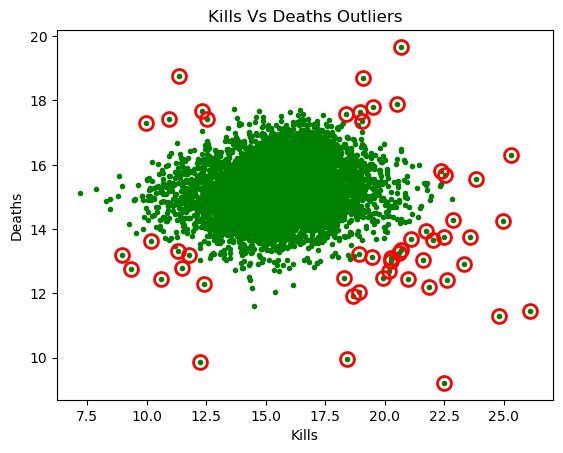

In [15]:
plt.plot(avg_data["kills"], avg_data["deaths"], 'g.')

plt.plot(anom_true["kills"].to_numpy(), anom_true["deaths"].to_numpy(), 'or',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)
plt.xlabel("Kills")
plt.ylabel("Deaths")
plt.title("Kills Vs Deaths Outliers")

In [16]:
anom_true

,kills,deaths,anomaly
user_id,,,
2006 Ford F250#beep,9.333333,12.769231,-1
2321#00000,20.263158,13.105263,-1
AdanNoAim7#6969,18.950000,17.650000,-1
Angelas duo#0000,22.606061,12.424242,-1
BIO GpixL#BIO,18.373333,17.583333,-1
Billy#Bob,18.394231,9.971154,-1
Blade#3091,11.350000,18.750000,-1
Cringe#1578,12.217949,9.858974,-1
Cwammycwam79#nerds,21.850000,12.200000,-1


In [17]:
high_dim_data = df.drop(["match_player_id", 
"date", 
"rounds", 
"map", 
"result", 
"agent",
"smurf",
"current_rank",
"grenade_casts",
"ability_2_casts",
"ability_1_casts",
"ultimate_casts",], axis=1)


In [18]:
avg_high_dim_data = high_dim_data.groupby("user_id").mean()
avg_high_dim_data.head()

,kills,headshots,deaths,assists,damage,damage_received,econ_rating,plants,defuses,first_bloods,placement,kdratio,headshot_percentage,first_deaths,last_deaths
user_id,,,,,,,,,,,,,,,
000#Angel,16.066667,10.460000,14.663333,4.263333,3035.400000,2860.116667,65.773333,0.496667,0.380000,2.316667,5.196667,1.283333,24.110006,1.960000,2.200000
007#0101,16.590000,11.713333,16.253333,3.313333,3047.990000,3089.820000,57.020000,0.436667,0.296667,3.143333,5.050000,1.120000,29.801248,2.993333,1.650000
00Slade#NA1,15.993333,10.493333,14.430000,6.536667,3024.140000,2734.270000,58.663333,1.700000,0.403333,1.833333,5.023333,1.226667,21.784829,1.583333,2.483333
01000101#NA1,14.596667,9.233333,15.190000,5.790000,2785.880000,2926.673333,54.876667,2.526667,0.390000,1.400000,6.306667,1.066667,24.125524,1.336667,2.190000
0ClF#519,15.400000,10.000000,14.930000,4.816667,2872.456667,2831.420000,55.220000,1.426667,0.450000,1.850000,5.770000,1.170000,25.912547,1.900000,2.430000


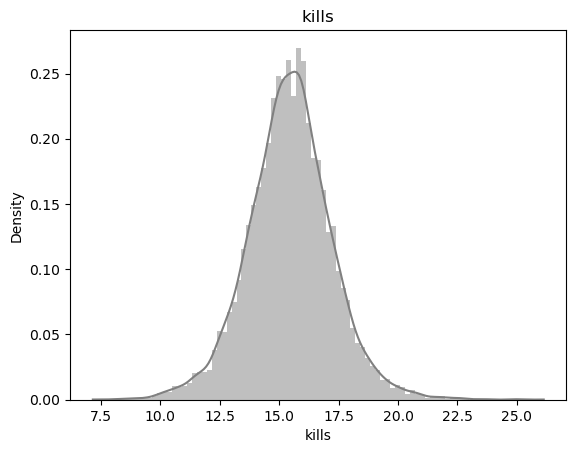

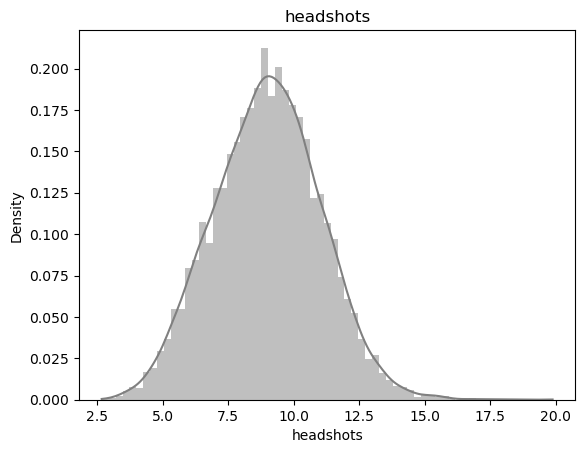

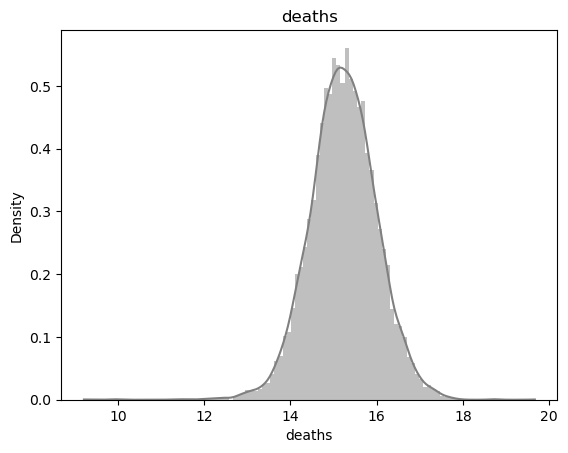

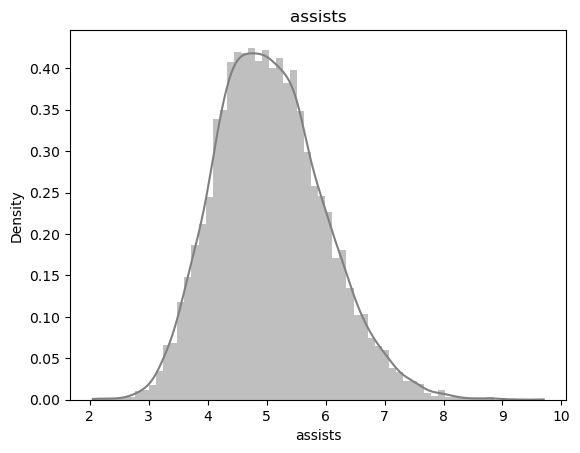

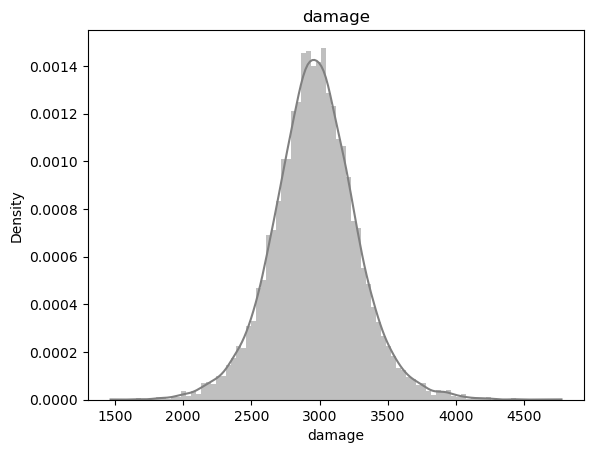

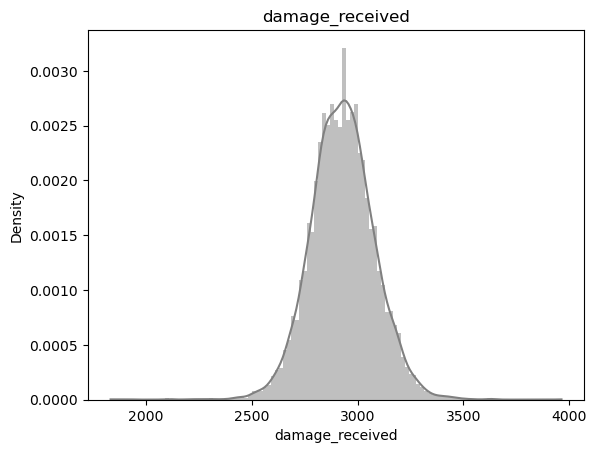

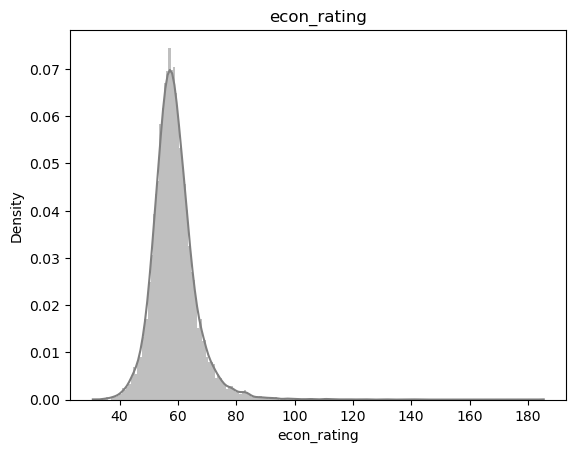

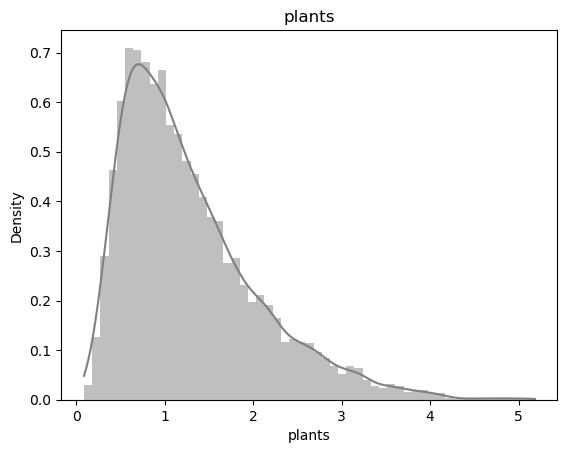

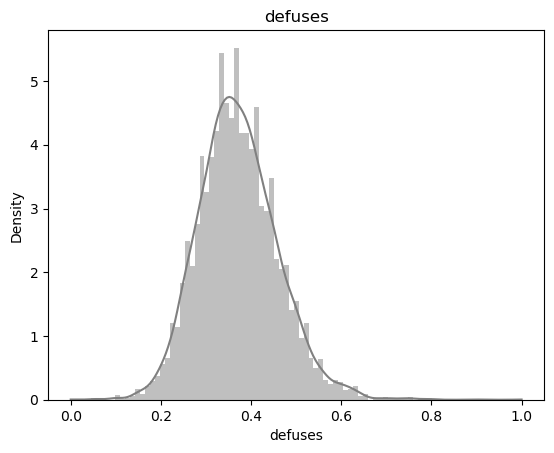

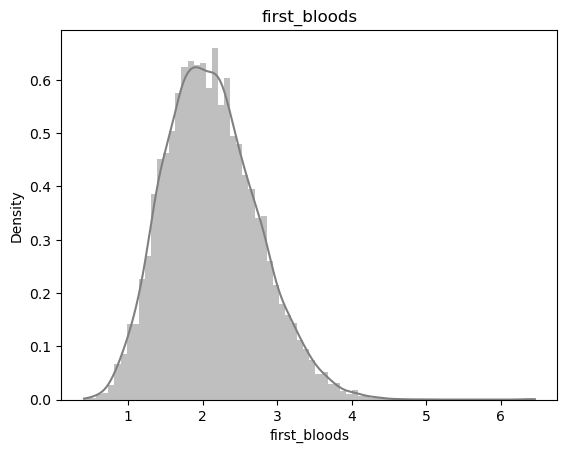

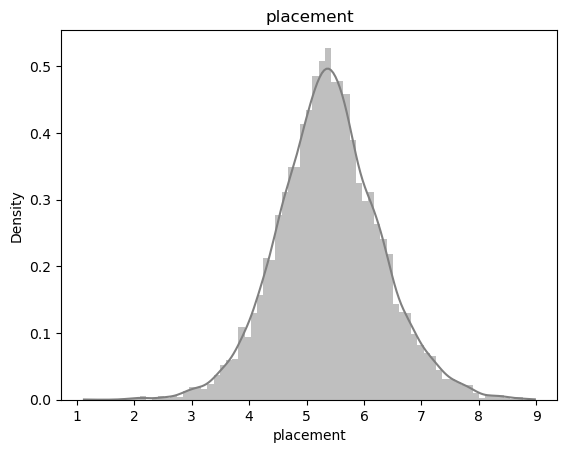

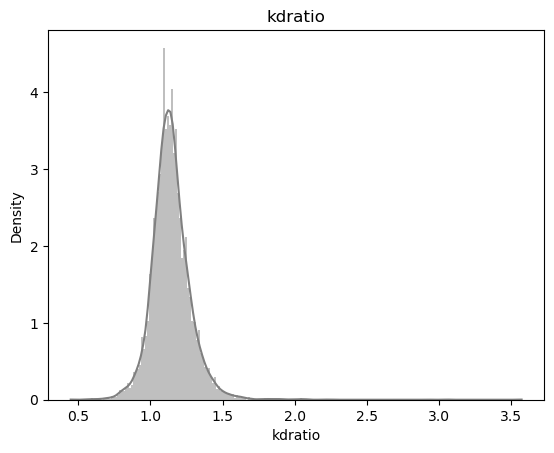

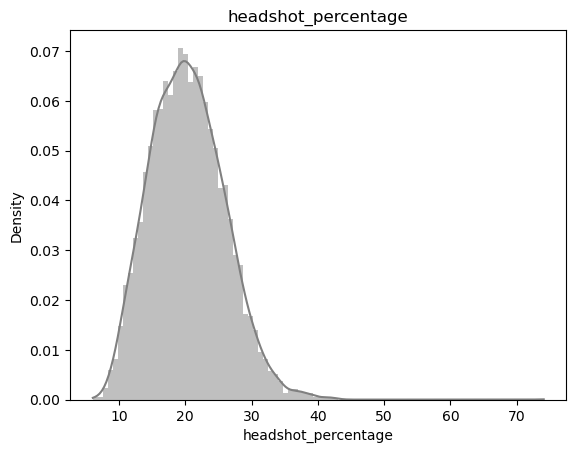

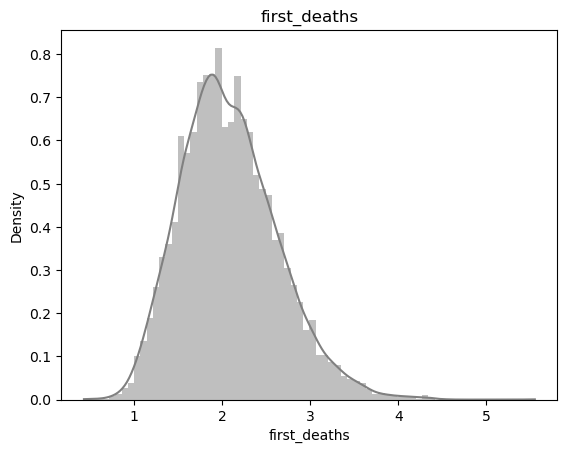

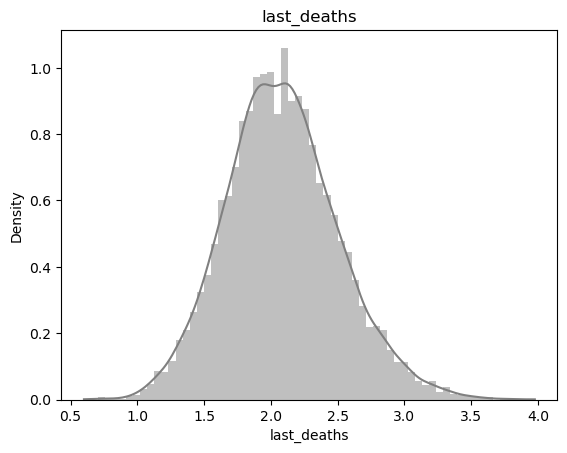

In [19]:
import seaborn as sns
for col in avg_high_dim_data:
    sns.histplot(avg_high_dim_data[col], color="grey", label="100% Equities", kde=True, stat="density", linewidth=0)
    plt.title(col)
    plt.show()

In [20]:
from sklearn.ensemble import IsolationForest

isof = IsolationForest(n_estimators=500, max_samples='auto', contamination=float(0.006))
clf = isof.fit(avg_high_dim_data)

In [21]:
anomaly_high_dim = clf.predict(avg_high_dim_data)

In [22]:
test_anomaly_high_dim = avg_high_dim_data
test_anomaly_high_dim["anomaly"] = anomaly_high_dim.tolist()
anomalies_high_dim = test_anomaly_high_dim[(test_anomaly_high_dim["anomaly"] == -1)]
print("Anomalies flagged: " + str(anomalies_high_dim.shape[0]))
anom_true_high_dim = anomalies_high_dim[(anomalies_high_dim["anomaly"] == -1)]
anom_true_high_dim

Anomalies flagged: 52


,kills,headshots,deaths,assists,damage,damage_received,econ_rating,plants,defuses,first_bloods,placement,kdratio,headshot_percentage,first_deaths,last_deaths,anomaly
user_id,,,,,,,,,,,,,,,,
2006 Ford F250#beep,9.333333,3.743590,12.769231,4.179487,1778.897436,2298.179487,47.307692,1.512821,0.256410,1.897436,7.846154,0.692308,11.278079,1.743590,1.230769,-1
2321#00000,20.263158,11.631579,13.105263,4.105263,3703.578947,2681.578947,83.315789,0.473684,0.631579,3.210526,3.631579,1.842105,21.555708,2.000000,2.368421,-1
Angelas duo#0000,22.606061,15.515152,12.424242,4.484848,4258.272727,2559.848485,124.727273,0.606061,0.272727,4.090909,2.090909,1.757576,26.198937,1.727273,1.363636,-1
Billy#Bob,18.394231,11.682692,9.971154,4.567308,3509.192308,2108.605769,89.423077,1.221154,0.413462,3.028846,2.865385,2.086538,21.929741,1.490385,1.346154,-1
Blade#3091,11.350000,4.500000,18.750000,4.850000,2400.550000,3430.750000,44.300000,0.300000,0.300000,2.550000,7.300000,0.550000,10.087577,5.550000,1.150000,-1
BlasiaN#MAMBA,20.657895,13.763158,14.184211,5.289474,3821.815789,2860.157895,77.578947,3.868421,0.631579,1.368421,3.315789,1.631579,26.711595,0.763158,2.921053,-1
Bradmpoke#8888,10.045226,3.698492,15.035176,5.582915,1961.864322,2783.864322,40.869347,3.804020,0.306533,0.683417,8.140704,0.798995,10.265449,1.376884,2.361809,-1
ChannyBananny#1850,11.983333,4.570000,14.153333,5.403333,2320.856667,2687.203333,46.090000,4.993333,0.593333,0.863333,7.516667,1.013333,9.708382,1.020000,3.410000,-1
Cringe#1578,12.217949,6.307692,9.858974,3.294872,2464.205128,1919.782051,116.807692,0.307692,0.128205,1.923077,5.384615,1.538462,14.829750,1.461538,1.166667,-1


In [23]:
anom_with_id = anom_true_high_dim.reset_index()
for user in anom_with_id["user_id"]:
    df.loc[df["user_id"] == user, 'smurf'] = 1

In [24]:
smurf_count = df.loc[df["smurf"] == 1].shape[0]
legit_count = df.loc[df["smurf"] == 0].shape[0]
print("Number of users flagged as a smurf: " + str(smurf_count))
print("Number of users not flagged: " + str(legit_count))

Number of users flagged as a smurf: 6647
Number of users not flagged: 2374056


In [25]:
smurf_ratio = smurf_count / (smurf_count + legit_count)
print("Smurf percentage: %.2f%%" % (smurf_ratio * 100))

Smurf percentage: 0.28%


In [26]:
from sklearn.utils import resample

df_majority = df[df["smurf"]==0]
df_minority = df[df["smurf"]==1]

df_minority_upsampled = resample(df_minority,
                                replace=True,
                                    n_samples=legit_count,
                                    random_state=111)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled["smurf"].value_counts()

0    2374056
1    2374056
Name: smurf, dtype: int64

"Running the upsampled data through a simple random forest model\n"

In [27]:
from sklearn.model_selection import train_test_split
df_upsampled = df_upsampled.dropna()
df_upsampled = df_upsampled.sample(frac=1)
y = np.array(df_upsampled['smurf'])
X = df_upsampled.drop(['smurf', 'date', 'match_player_id', 'user_id'], axis = 1)


In [28]:
numeric = X[X.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]']).columns]
for feature in numeric:
    dummies = pd.get_dummies(X[feature])
    X = pd.concat([X, dummies], axis=1)
    X = X.drop([feature], axis=1)
print(X.head)

<bound method NDFrame.head of          rounds  kills  headshots  deaths  assists  damage  damage_received  \
1476692      25     13          5      20        9    4285             4651   
126629       25     24         15      15        3    3579             3176   
1995575      25     33         19      19        3    6034             4048   
2339064      25      6          4      20        5    1279             3734   
1430306      25      5          4      15       14    1285             2559   
...         ...    ...        ...     ...      ...     ...              ...   
1065600      25      7          3      15        8    1467             2765   
308624       25     16         11      16        1    3219             3290   
1712498      25     18         12      17        4    3563             3218   
113017       25     19          6      18        7    3531             3050   
1329404      25     26         13      14        2    4415             2371   

         econ_rating 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)


"Using Random Forest because we have a very large data set. The main drawback is interprtability would be usefull to see where and why certain splits happen. However, we do have access to feature importance since we used Random Forest"

The radom forest model above takes about 23 minutes to execute so lets save it in a joblib dump to reuse. 


In [30]:
smurf_df = df[df["smurf"]==1]
legit_df = df[df["smurf"]==0].sample(n=smurf_df.shape[0])
print("Number of accounts flagged as a smurf: " + str(smurf_df.shape[0]))
print("Number of accounts not flagged: " + str(legit_df.shape[0]))
new_sample_df = pd.concat([smurf_df, legit_df])



Number of accounts flagged as a smurf: 6647
Number of accounts not flagged: 6647


In [31]:
from sklearn.model_selection import train_test_split
new_sample_df = new_sample_df.dropna()
new_sample_df = new_sample_df.sample(frac=1)
y = np.array(new_sample_df['smurf'])
X = new_sample_df.drop(['smurf', 'date', 'match_player_id', 'user_id'], axis = 1)

In [32]:
numeric = X[X.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]']).columns]
for feature in numeric:
    dummies = pd.get_dummies(X[feature])
    X = pd.concat([X, dummies], axis=1)
    X = X.drop([feature], axis=1)
print(X.head)

<bound method NDFrame.head of          rounds  kills  headshots  deaths  assists  damage  damage_received  \
1329418      25     33         21       7        2    5355             1891   
1131300      25     17          6      20        5    3272             3738   
2144922      25     24         10      13       12    4031             2758   
1261057      25     17         11      14        7    3896             2597   
1409512      25     13          9      20        3    2650             3879   
...         ...    ...        ...     ...      ...     ...              ...   
1794018      25      4          3       9        1     805             1720   
1512823      25     13          4      11        6    3248             2411   
2339151      25     14          6      20        5    2553             3691   
1775737      25     10          7      16        4    2104             2772   
391060       25     11          5       6        8    2121             1281   

         econ_rating 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=100, max_features=9)

rf.fit(X_train, y_train)
rf_predict=rf.predict(X_test)

# #print confusion matrix and accuracy score\n",
rf_conf_matrix = confusion_matrix(y_test, rf_predict)
rf_acc_score = accuracy_score(y_test, rf_predict)
print("Confusion Matrix:")
print(rf_conf_matrix)
accuracy = rf_acc_score*100
print("Accuracy: " + str(accuracy))

Confusion Matrix:
[[2643  667]
 [ 765 2453]]
Accuracy: 78.06372549019608


This is a much more accaptable accuracy without any oversampling. 77% is not great, but it is reliable.

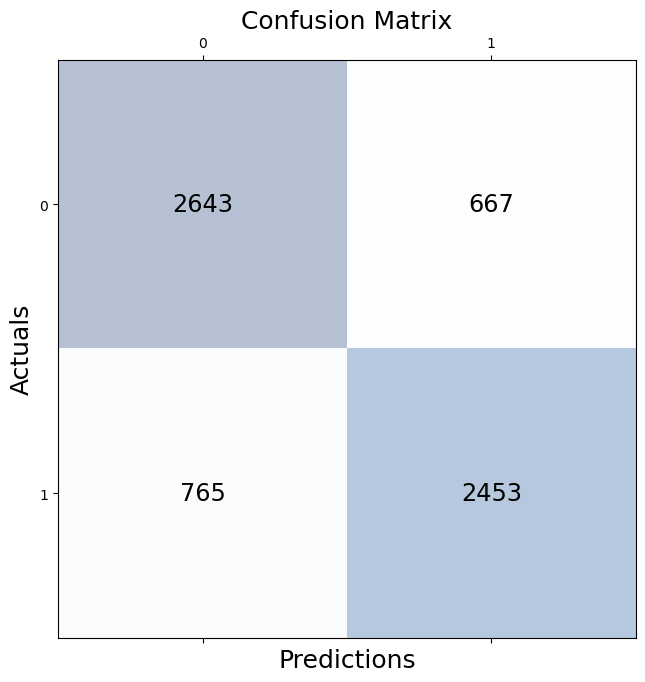

In [35]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(rf_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(rf_conf_matrix.shape[0]):
    for j in range(rf_conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=rf_conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

<BarContainer object of 78 artists>

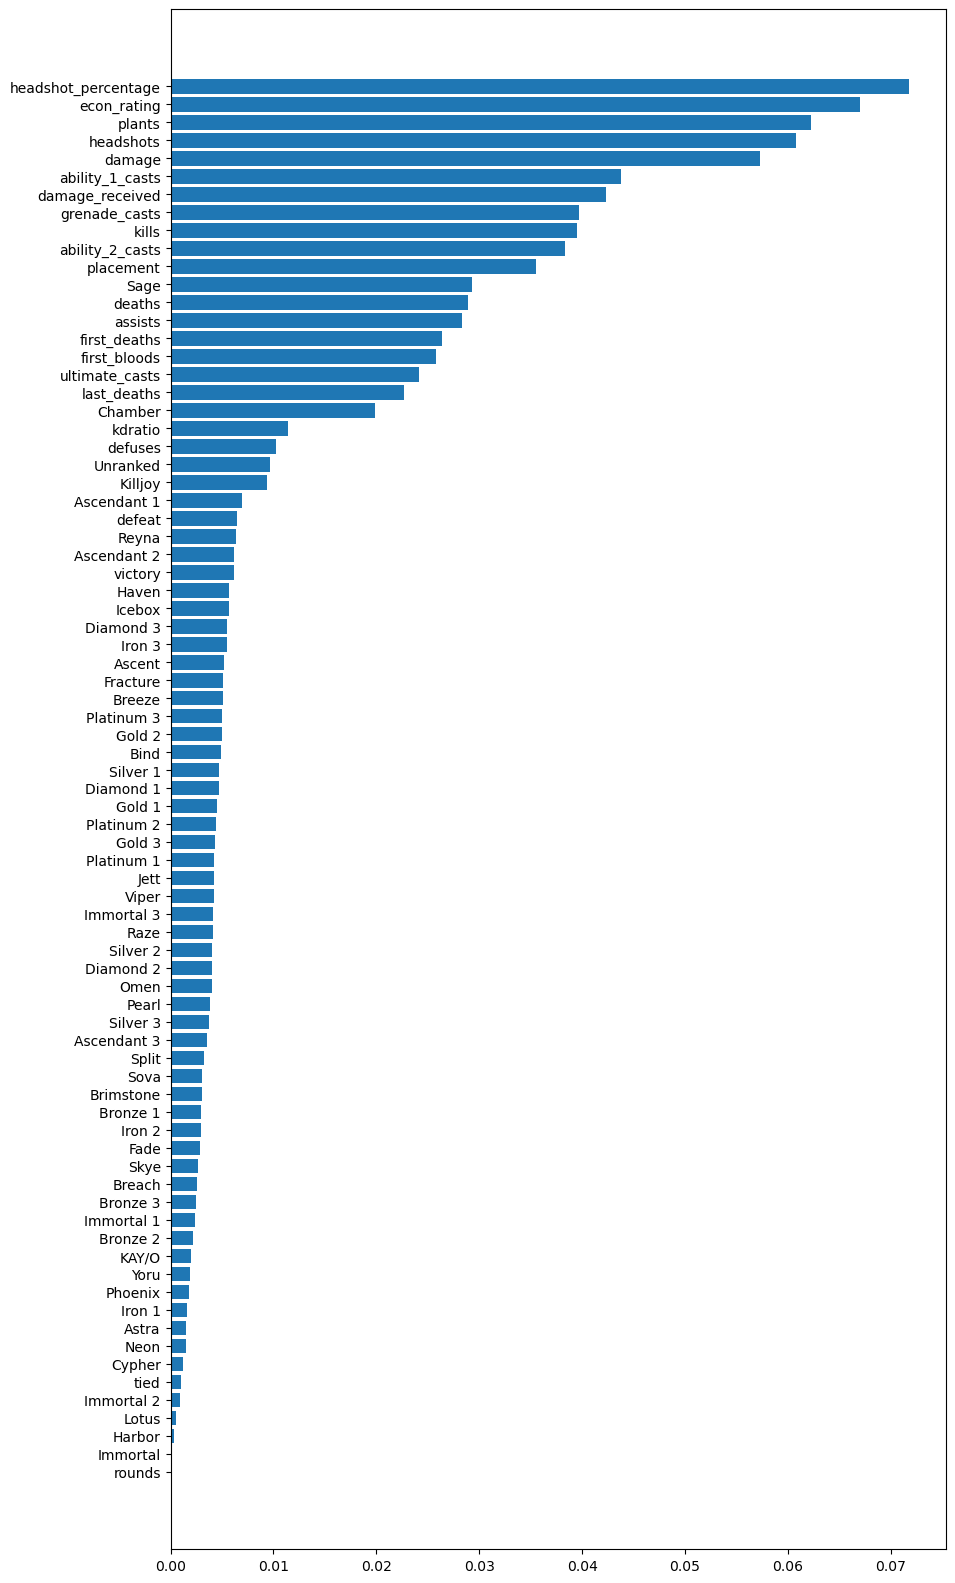

In [36]:
imp_df =  pd.DataFrame()
imp_df["feature"] = X_train.columns
imp_df["importance"] = rf.feature_importances_
imp_df_sorted = imp_df.sort_values(by=["importance"])
plt.figure(figsize=(10, 20))
plt.barh(imp_df_sorted["feature"], imp_df_sorted["importance"])

This plot is very interesting and provides some more insight on what attributes can be focused on to detect smurfs. Before it was assumed that kills, deaths and headshot percentage would be the most important traits for smurf detection but as we can see here 'econ_rating', 'damage_recieved', 'ability_1_casts' are also considered very important features. It is also interesting to see how different agent and ranks differ importance. 

In [37]:
top_features = imp_df_sorted["feature"][-4:]
top_features

2               headshots
8                  plants
7             econ_rating
17    headshot_percentage
Name: feature, dtype: object

Lets see what anomaly detection will look like with the 2 most important features.

In [38]:
def twodvisual(first, second):
    sub_data = df[[first, second, "user_id"]]
    avg_data = sub_data.groupby("user_id").mean()

    from sklearn.ensemble import IsolationForest

    isof = IsolationForest(n_estimators=500, max_samples='auto', contamination=float(0.006))
    clf = isof.fit(avg_data)

    anomaly = clf.predict(avg_data)


    test_anomaly = avg_data
    test_anomaly["anomaly"] = anomaly.tolist()

    anomalies = test_anomaly[(test_anomaly["anomaly"] == -1)]

    anom_true = anomalies[(anomalies["anomaly"] == -1)]

    plt.plot(avg_data[first], avg_data[second], 'g.')

    plt.plot(anom_true[first].to_numpy(), anom_true[second].to_numpy(), 'or',
            markersize= 10,markerfacecolor='none', markeredgewidth=2)
    plt.xlabel(first)
    plt.ylabel(second)
    plt.title(first + " Vs " + second + " Outliers")

In [39]:
def twodvisual(first, second):
    plt.plot(avg_high_dim_data[first], avg_high_dim_data[second], 'g.')

    plt.plot(anom_true_high_dim[first].to_numpy(), anom_true_high_dim[second].to_numpy(), 'or',
                markersize= 10,markerfacecolor='none', markeredgewidth=2)
    plt.xlabel(first)
    plt.ylabel(second)
    plt.title(first + " Vs " + second + " Outliers")
    plt.show()

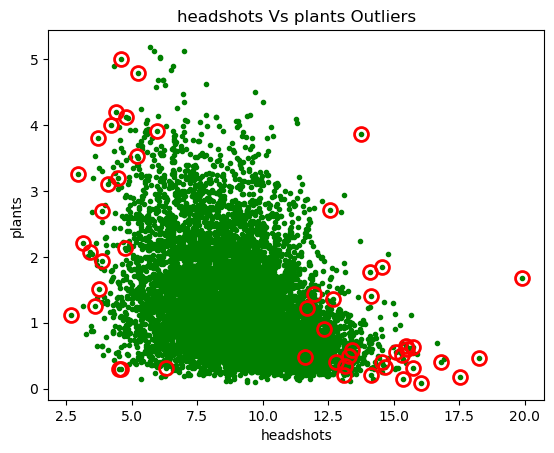

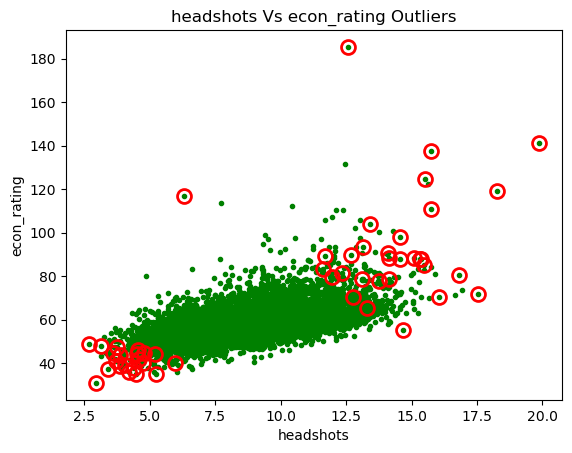

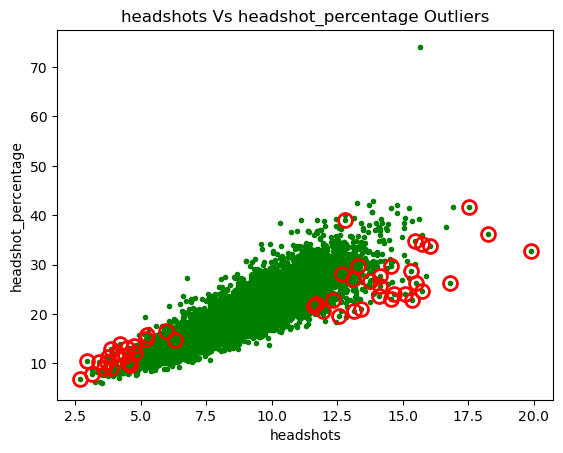

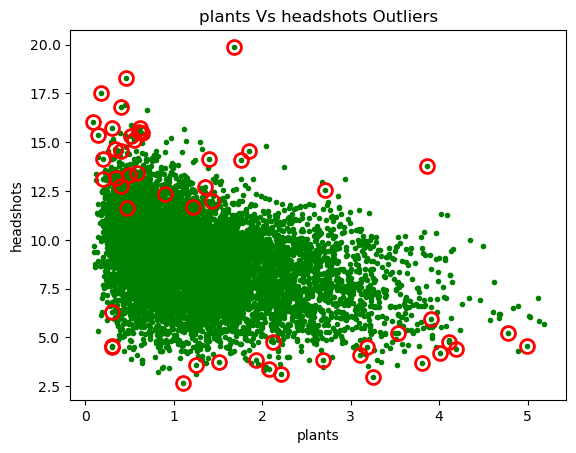

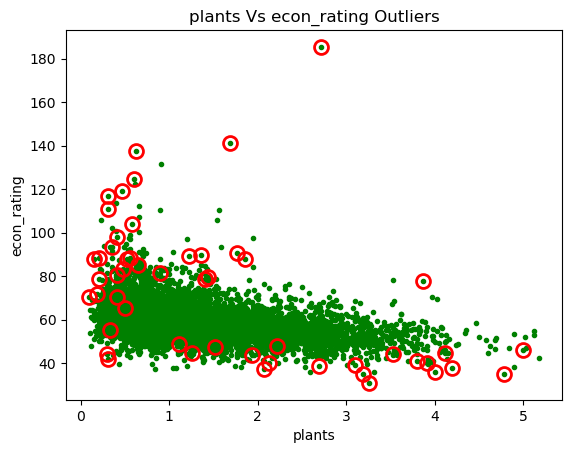

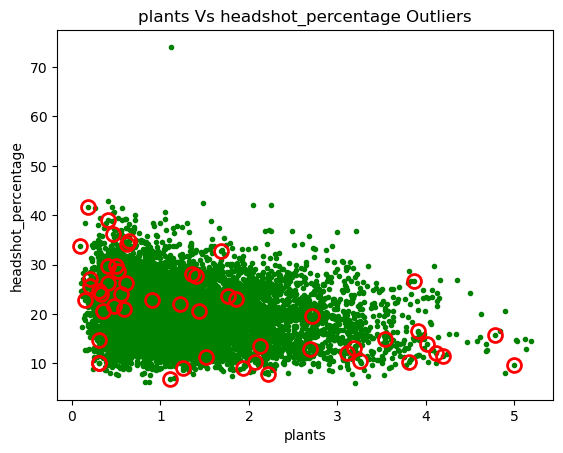

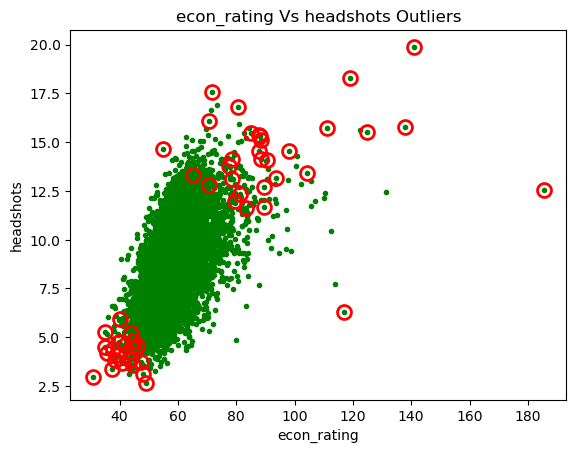

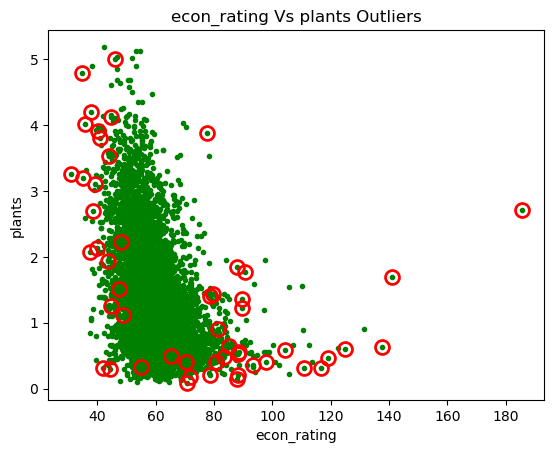

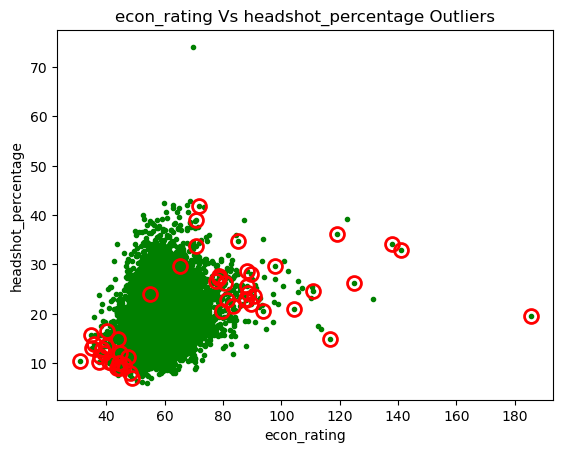

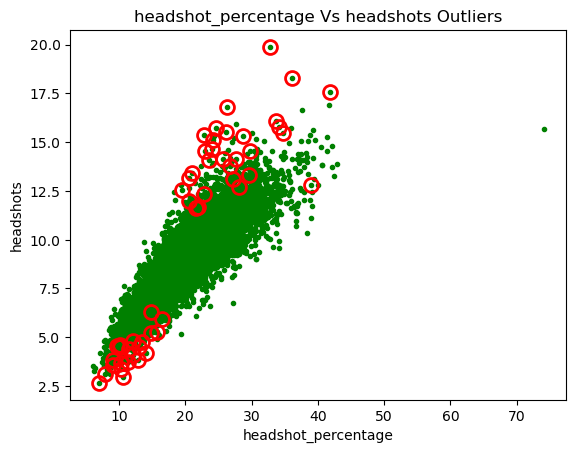

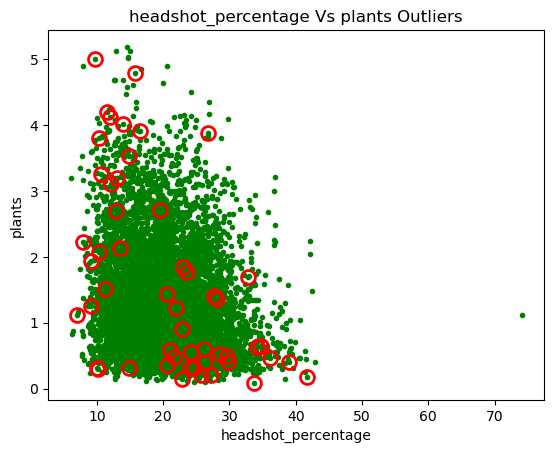

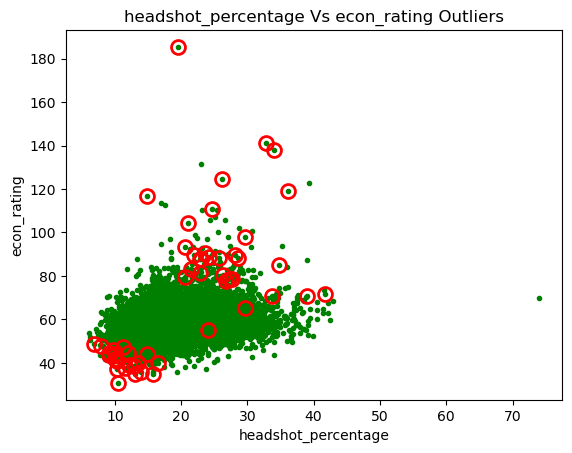

In [40]:
for first in top_features:
    for second in top_features:
        if(first != second):
            twodvisual(first, second)